<img src="logo vortex.png" style="width: 40px; height: auto;"><font color=purple size=12px>PREVENÇÃO DE QUEDAS</font>


# 

#
<font color=blue size=10px>1 - Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


#
<font color=blue size=10px>2 - Pré processamento dos dados

In [2]:
# mudando os nomes para preservar a identidade dos voluntários
dados = pd.read_excel('dados_quedas.xlsx')
nomes_unicos = dados['VOLUNTARIO'].unique()
mapeamento_nomes = {nome: f'voluntario{i+1}' for i, nome in enumerate(nomes_unicos)}
dados['VOLUNTARIO'] = dados['VOLUNTARIO'].map(mapeamento_nomes)


In [3]:
# transformando as posicoes em one hot
encoder = OneHotEncoder(sparse=False)
POSICAO_encoded = encoder.fit_transform(dados[['POSICAO']])
POSICAO_df = pd.DataFrame(POSICAO_encoded, columns=encoder.get_feature_names_out(['POSICAO'])) # meu Y

dados = pd.concat([dados, POSICAO_df], axis=1)


c:\Users\Pichau\anaconda3\envs\tfgpu\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
# remoção dos ruídos pela formula dos quartis
def remove_outliers(db):
    for col in ['A', 'B', 'C', 'D']:
        
        Q1 = db[col].quantile(0.25)
        Q3 = db[col].quantile(0.75)
        
        IIQ = Q3 - Q1
        lower_limit = Q1 - 1.5 * IIQ
        upper_limit = Q3 + 1.5 * IIQ
        selecao = (db[col] >= lower_limit) & (db[col] <= upper_limit)
        
        db = db[selecao]
    return db

# salvando dados ja analisados
dados = dados.groupby(['VOLUNTARIO', 'POSICAO']).apply(remove_outliers)

# DEPOIS QUE EXECUTAR ESSA CELULA, COMENTE A LINHA ABAIXO, NAO PRECISAS SALVAR NOVAMENTE!!
#dados.to_csv('dados_analisado.csv', sep = ';', index = False ) 

In [5]:
# removendo duas pessoas dos dados para serem usados mais tarde na validação
voluntarios_validacao = ['voluntario3', 'voluntario14']
auxiliar = dados['VOLUNTARIO'].isin(voluntarios_validacao)
dados_validacao = dados[auxiliar]
auxiliar = ~dados['VOLUNTARIO'].isin(voluntarios_validacao)
dados_treino = dados[auxiliar]


#
<font color=blue size=10px>3 - Definições e treinamento

In [6]:
# verificando se a placa de vídeo está sendo utilizada
if tf.config.experimental.list_physical_devices('GPU'):
    print("utilizando placa de video")
else:
    print("rodando na cpu, reinicie o processo")


utilizando placa de video


In [7]:
# criar o point para salvar os pesos de 2 em 2 epocas de cada fold
def create_checkpoint(fold_num):
    filepath = f'modelos salvos/melhor_modelo_fold{fold_num:02d}_epoch{{epoch:02d}}.hdf5'
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        save_weights_only=True,
        save_best_only=False,
        monitor='val_loss',
        verbose=1,
        period=2)
    return checkpoint


# callback de redução de taxa de aprendizado, reduz em 50% se nai mudar em 3 epocas
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=3,
    min_lr=0.000001,
    verbose=1)

In [8]:
# hiperparametros
camada_1 = 1024
camada_2 = 512
lr = 0.0005
folds = 5
batch = 5000 #X_treino.shape[0]
funcao_perda ='categorical_crossentropy' #'mean_absolute_error' #'mean_squared_error' 'categorical_crossentropy'
otimizador = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
epocas = 50
kf = KFold(n_splits=folds, shuffle=True, random_state=12345)

# definindo arquitetura da rede
def MLP():
    model = Sequential()
    model.add(Dense(camada_1, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(camada_2, activation='relu'))
    model.add(Dense(12, activation='softmax'))

    model.compile(loss=funcao_perda, optimizer=otimizador, metrics=['accuracy'])
    return model
    

In [9]:
X = dados_treino[['A', 'B', 'C', 'D']]
Y = dados_treino[POSICAO_df.columns]

In [10]:
# treinamento
fold_num = 1

for index_treino, index_teste in kf.split(X):
    X_treino, X_teste = X.iloc[index_treino], X.iloc[index_teste]
    Y_treino, Y_teste = Y.iloc[index_treino], Y.iloc[index_teste]

    model = MLP()

    checkpoint = create_checkpoint(fold_num)

    model.fit(X_treino,
              Y_treino, 
              epochs=epocas,
              batch_size=batch, 
              validation_data=(X_teste, Y_teste), 
              callbacks=[checkpoint, reduce_lr])

    scores = model.evaluate(X_teste, Y_teste)
    print(f"metricas da fold: {scores}")

    fold_num += 1



Epoch 1/50
50/50 [==============================] - 1s 7ms/step - loss: 0.7290 - accuracy: 0.8380 - val_loss: 0.3230 - val_accuracy: 0.9001 - lr: 5.0000e-04
Epoch 2/50
46/50 [==========================>...] - ETA: 0s - loss: 0.2619 - accuracy: 0.9094
Epoch 2: saving model to modelos salvos\melhor_modelo_fold01_epoch02.hdf5
50/50 [==============================] - 0s 5ms/step - loss: 0.2598 - accuracy: 0.9100 - val_loss: 0.2314 - val_accuracy: 0.9209 - lr: 5.0000e-04
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.2195 - accuracy: 0.9223 - val_loss: 0.2137 - val_accuracy: 0.9214 - lr: 5.0000e-04
Epoch 4/50
43/50 [========================>.....] - ETA: 0s - loss: 0.2037 - accuracy: 0.9277
Epoch 4: saving model to modelos salvos\melhor_modelo_fold01_epoch04.hdf5
50/50 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.9275 - val_loss: 0.2003 - val_accuracy: 0.9250 - lr: 5.0000e-04
Epoch 5/50
50/50 [==============================] - 0s 4ms

#
<font color=blue size=10px>4 - Validaçao da RNA

In [11]:
X_teste = dados_validacao[['A', 'B', 'C', 'D']]
Y_teste = dados_validacao[POSICAO_df.columns]

Y_teste_classes = np.argmax(Y_teste.values, axis=1)

In [12]:
resultados = []

for fold_num in range(1, folds+1):
    for epoch in range(2, epocas + 1, 2):
        modelo_validacao = MLP()
        try:
            modelo_validacao.load_weights(f'modelos salvos/melhor_modelo_fold{fold_num:02d}_epoch{epoch:02d}.hdf5')

            Y_pred = modelo_validacao.predict(X_teste)
            Y_pred_classes = np.argmax(Y_pred, axis=1)

            metricas = {
                'fold': fold_num,
                'epoch': epoch,
                'acuracia': accuracy_score(Y_teste_classes, Y_pred_classes),
                'precisao': precision_score(Y_teste_classes, Y_pred_classes, average='macro'),
                'recall': recall_score(Y_teste_classes, Y_pred_classes, average='macro'),
                'f1-score': f1_score(Y_teste_classes, Y_pred_classes, average='macro')
            }
            resultados.append(metricas)
        except FileNotFoundError:
            print(f"Modelo para fold {fold_num} e epoch {epoch} não encontrado.")

# salvando os resultados em um csv para analise
resultados_df = pd.DataFrame(resultados)
resultados_df.to_csv('resultados.csv', sep = ';', index = False ) 


1341/1341 [==============================] - 1s 935us/step


In [13]:
# verificando qual época teve maior acuracia na validacao para impressao da matriz de confusao
resultados_df.style.apply(lambda x: ['background-color: lightblue' if x['acuracia'] > 0.95 else '' for _ in x], axis=1)


,fold,epoch,acuracia,precisao,recall,f1-score
0,1,2,0.956369,0.956148,0.965818,0.959980
1,1,4,0.925580,0.938530,0.942692,0.938320
2,1,6,0.936721,0.948838,0.956174,0.950672
3,1,8,0.940986,0.951882,0.957684,0.953745
4,1,10,0.935532,0.947082,0.955537,0.949140
5,1,12,0.913973,0.931226,0.935410,0.929961
6,1,14,0.910150,0.928501,0.933273,0.927197
7,1,16,0.921990,0.937269,0.940429,0.936555
8,1,18,0.917329,0.934466,0.936095,0.932186
9,1,20,0.916653,0.933434,0.937844,0.932818


1341/1341 [==============================] - 1s 900us/step


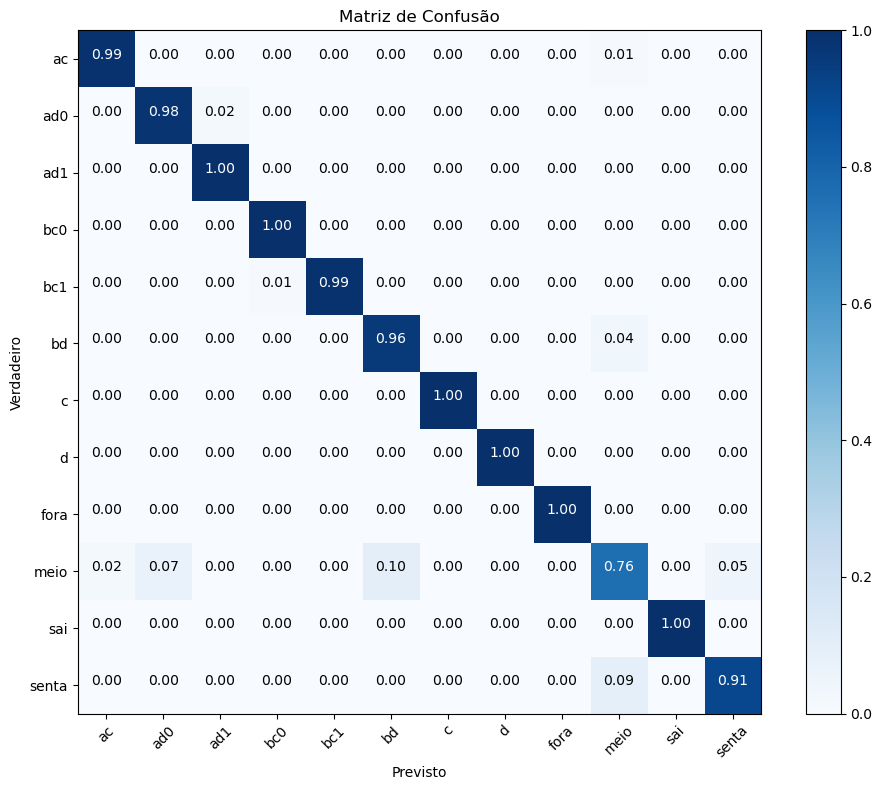

In [23]:
# de acordo com a tabela acima escolha qual modelo você quer imprimir a matriz de confusao
fold_escolhido = 4
epoch_escolhida = 2
modelo_validacao = MLP()
modelo_validacao.load_weights(f'modelos salvos/melhor_modelo_fold{fold_escolhido:02d}_epoch{epoch_escolhida:02d}.hdf5')

Y_pred = modelo_validacao.predict(X_teste)
Y_pred_classes = np.argmax(Y_pred, axis=1)

matriz_confusao = confusion_matrix(Y_teste_classes, Y_pred_classes)
matriz_confusao_normalizada = matriz_confusao.astype('float') / matriz_confusao.sum(axis=1)[:, np.newaxis]

POSICAO_labels = dados_validacao['POSICAO'].unique()

def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.tight_layout()


plt.figure(figsize=(10, 8))
# se o normalize for False, vai ser as ocorrencias ao inves de %
plot_confusion_matrix(matriz_confusao_normalizada, classes=POSICAO_labels, normalize=True)
plt.show()


#
<font color=blue size=10px>5 - Outros algoritmos de ML

In [15]:
def compute_multiclass_metrics(y_true, y_pred):
    acuracia = accuracy_score(y_true, y_pred)
    precisao = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return acuracia, precisao, recall, f1

resultados = {}


##
<font color=green size=6px>5.1 - Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid_dt = {'max_depth': [10, 15, 20, 25, 50], 'min_samples_split': [2, 5, 10, 15, 30]}
dt_model = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5)
grid_search_dt.fit(X, Y)
melhor_dt_model = grid_search_dt.best_estimator_

dt_pred = melhor_dt_model.predict(X_teste)
resultados['decision tree'] = compute_multiclass_metrics(Y_teste, dt_pred)


##
<font color=green size=6px>5.2 - Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100, 150], 'max_features': ['sqrt']}
rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)
grid_search_rf.fit(X, Y)
melhor_rf_model = grid_search_rf.best_estimator_

rf_pred = melhor_rf_model.predict(X_teste)
resultados['Random Forest'] = compute_multiclass_metrics(Y_teste, rf_pred)

##
<font color=green size=6px>5.3 - KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {'n_neighbors': [3, 5]}
knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5)
grid_search_knn.fit(X, Y)
best_knn_model = grid_search_knn.best_estimator_

knn_predictions = best_knn_model.predict(X_teste)
resultados['KNN'] = compute_multiclass_metrics(Y_teste, knn_predictions)


##
<font color=green size=6px>5.4 - Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

Y_1d = np.argmax(Y, axis=1) if isinstance(Y, np.ndarray) else Y.idxmax(axis=1)
Y_teste_1d = np.argmax(Y_teste, axis=1) if isinstance(Y_teste, np.ndarray) else Y_teste.idxmax(axis=1)

param_grid_nb = {'var_smoothing': [1e-9]} 
nb_model = GaussianNB()
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5)
grid_search_nb.fit(X, Y_1d)
best_nb_model = grid_search_nb.best_estimator_

nb_predictions = best_nb_model.predict(X_teste)
resultados['Naive Bayes'] = compute_multiclass_metrics(Y_teste_1d, nb_predictions)


#
<font color=blue size=10px>6 - Resultados

In [24]:
resultados['MLP'] = resultados_df.loc[75, ['acuracia', 'precisao', 'recall', 'f1-score']]

In [25]:
resultados_df = pd.DataFrame(resultados, index=['acuracia', 'precisao', 'recall', 'f1-score']).T
resultados_df

,acuracia,precisao,recall,f1-score
decision tree,0.773406,0.812982,0.817352,0.804392
Random Forest,0.837129,0.924140,0.868307,0.885250
KNN,0.872649,0.893024,0.897466,0.891975
Naive Bayes,0.873861,0.898294,0.895923,0.894308
MLP,0.951055,0.960218,0.965367,0.962082
